### Importing Essential Libraries

In [1]:
# !pip install transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

from transformers import logging
logging.set_verbosity_error()

In [2]:
import time
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 700) 

from matplotlib import pyplot as plt
%matplotlib inline
# !pip install seaborn
import seaborn as sns
import random, os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch import nn
from torch.nn import Sequential, Module, ModuleList, Linear, Dropout
from torch.nn import ReLU, LeakyReLU, Sigmoid, GELU
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, LinearLR
# !pip install torchmetrics
from torchmetrics import F1Score, Precision, Recall, Accuracy, ConfusionMatrix

# !pip install torchtext
import torchtext

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


### Google Drive and Relative Paths

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# ROOT = 'gdrive/My Drive/ai2_data/1/' # ^ Google drive  
ROOT = '../input/ai2-4-data/' # Kaggle
# ROOT = './' # local

OUT          = '/kaggle/working/'
DATASETS     = OUT + 'datasets/'
SAVED_MODELS = OUT + 'saved_models/'
PLOTS        = OUT + 'plots/'
import os

paths = [OUT + 'datasets', OUT + 'saved_models', OUT + 'plots',
         PLOTS + 'f1', PLOTS + 'loss', PLOTS + 'roc']

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

### Helpers

In [4]:
def write_data(path, obj):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_data(path):
    return pd.read_pickle(path)

def load_csv(path, sep='\t'):
    return pd.read_csv(path, sep=sep)

### Reviews Cleanup 

In [5]:
def clean_df(df):
    df['new_rating'] = df['rating'] >= 7

    sw = stopwords.words('english') 

    sw.append('movie')
    sw.append('film')
    sw.append('br')
    
    sw.remove('not')
    sw.remove('no')

    sw = set(sw)

    df['clean_review'] = df['review'].str.lower()
    df['clean_review'] = df['clean_review'].str.replace('n\'t', ' not')
    df['clean_review'] = df['clean_review'].str.replace(r'(@\S+)|(#\S+)|(http\S+)|(www.\S+)', ' ', regex=True)
    df['clean_review'] = df['clean_review'].str.replace(r'[^a-z]', ' ', regex=True)
    df['clean_review'] = df['clean_review'].map(lambda x: ' '.join([word for word in word_tokenize(x) if not word in sw]))

    return df

### Dataset

In [6]:
class ClassifierData(Dataset):
    def __init__(self, dataset, x_label='clean_review', y_label='new_rating', load=True):
        
        df = load_data(dataset) if load else dataset

        # Load pre-trained model tokenizer (vocabulary)
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        encoded = tokenizer.batch_encode_plus(df[x_label].values,
                                              add_special_tokens=True,
                                              return_attention_mask=True,
                                            #   padding='max_length',
                                              padding=True, truncation=True,
                                              max_length=256, # 256 is max bert length
                                              return_tensors='pt'
                                            )

        self.inputs = encoded['input_ids']

        self.masks = encoded['attention_mask']

        self.labels = [float(i) for i in df[y_label].values]
        self.labels = torch.tensor(self.labels)
        self.labels = self.labels.unsqueeze(1)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.inputs[index], self.masks[index], self.labels[index]

In [7]:
def get_datasets(path):
    train = ClassifierData(path + 'train.pkl')
    val   = ClassifierData(path + 'val.pkl')
    test  = ClassifierData(path + 'test.pkl')
    return train, val, test

In [8]:
def get_dataloaders(train_data, val_data, test_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

### Train & Test 

In [9]:
def test(dataloader, model, loss_fn, device):
    model.eval()

    samples = len(dataloader)
    loss = 0.0
    predicted, target = [], []
    
    with torch.no_grad():
        for X, masks, y in dataloader:
            X = X.to(device)
            masks = masks.to(device)
            y = y.to(device)

            pred = model(input_ids=X, attention_mask=masks)   
            loss += loss_fn(pred, y).item()
       
            predicted.append(pred)             
            target.append(y)             
    
    predicted = torch.cat(predicted, dim=0).to(device)
    target = torch.cat(target, dim=0).to(device)

    p = Precision(task="binary", num_classes=2).to(device)
    r = Recall(task="binary", num_classes=2).to(device)
    f1 = F1Score(task="binary", num_classes=2).to(device)
    acc = Accuracy(task="binary", num_classes=2).to(device)

    p  =  p(predicted, target).item()
    r  =  r(predicted, target).item()
    f1 = f1(predicted, target).item()

    return loss / samples, p, r, f1, acc(predicted, target).item(), predicted.detach().cpu().numpy(), target.detach().cpu().numpy()

In [10]:
def epoch(model, device, dataloader, show_epochs, t, loss_fn, optimizer, scheduler, clip):
    model.train()
    running_loss = 0.0

    if show_epochs:
        print(f"\nEpoch {t+1}\n-------------------------------")

    predicted, target, losses = [], [], []

    for X, masks, y in dataloader:
        X = X.to(device)
        masks = masks.to(device)
        y = y.to(device)

        pred = model(input_ids=X, attention_mask=masks)   
    
        predicted.append(pred)             
        target.append(y)         

        loss = loss_fn(pred, y)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        if scheduler:
            scheduler.step()
    
    return predicted, target, running_loss

In [11]:
def validate_model(model, device, dataloader, show_epochs, epoch_loss, metrics, loss_fn, min_loss):
    val_loss, _, _, f1, _, _, _ = test(dataloader, model, loss_fn, device)
            
    if show_epochs:
        print(f'Loss on train set     : {epoch_loss}')
        print(f'Loss on validation set: {val_loss}')
        print(f'F1-score on validation set: {f1*100:>.2f}')

    metrics['loss']['test'].append(val_loss)
    metrics['f1']['test'].append(f1)

    if val_loss < min_loss:
        if show_epochs:
            print(f'Best epoch so far')
        write_data(f'{SAVED_MODELS}model_{device}.pth', model)
        min_loss = val_loss
    
    return metrics, min_loss

In [12]:
def train(dataloader, model, epochs, loss_fn, optimizer, val_dataloader=None, show_epochs=False, device='cpu', **kwargs):
    scheduler = kwargs['scheduler'] if 'scheduler' in kwargs else None
    clip = kwargs['clip'] if 'clip' in kwargs else None

    metrics = {'loss' : {'train' : [], 'test' : []}, 
               'f1' : {'train' : [], 'test' : []}}

    min_loss = float('inf')

    for t in range(epochs):
        batches = len(dataloader)

        predicted, target, running_loss = epoch(model, device, dataloader, show_epochs, t, loss_fn, optimizer, scheduler, clip)

        epoch_loss = running_loss / batches
        metrics['loss']['train'].append(epoch_loss)

        predicted = torch.cat(predicted, dim=0).to(device)
        target = torch.cat(target, dim=0).to(device)
        f1 = F1Score(task="binary", num_classes=2).to(device)
        metrics['f1']['train'].append(f1(predicted, target).item())

        if show_epochs and not val_dataloader:
            print(f"Epoch Average Loss: {epoch_loss:>7f}\n")

        if val_dataloader:
            metrics, min_loss = validate_model(model, device, val_dataloader, show_epochs, 
                                               epoch_loss, metrics, loss_fn, min_loss)
            
    return metrics

### Complete pass

#### Reproducibility

In [13]:
def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

#### Learning Curve

In [14]:
# Based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def helper(train, test, xlabel, ylabel, f1=False, id=None):
    fig, axes = plt.subplots(1, 1, figsize=(8,5))

    axes.set_xlabel('Epoch')
    axes.set_ylabel('F1-Score' if f1 else 'Loss')

    axes.grid()

    epoch_step = len(train) // 20
    if not epoch_step:
        epoch_step = 1

    xvalues = np.arange(1, len(train) + 1, epoch_step)

    axes.plot(xvalues, train[::epoch_step], "o-", color="r", label=xlabel)
    axes.plot(xvalues, test[::epoch_step], "o-", color="g", label=ylabel)

    axes.legend(loc="best")

    plt.xticks(np.arange(1, len(train) + epoch_step + 1, epoch_step))

    max_stat = max(max(train), max(test)) 
    step = 0.05 if f1 else max_stat / 10
    low = 0.50 if f1 else 0.
    high = 1.01 if f1 else max_stat + step

    plt.yticks(np.arange(low, high, step))

    if id:
        name = 'f1' if f1 else 'loss'
        fig.savefig(f'{PLOTS}{name}/{id}_{name}.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    

def learning_curve(metrics, id=None):
    helper(np.array(metrics['f1']['train']), np.array(metrics['f1']['test']), 'Training F1-Score', 'Validation F1-Score', f1=True, id=id)
    helper(np.array(metrics['loss']['train']), np.array(metrics['loss']['test']), 'Training loss', 'Validation loss', id=id)

#### ROC curve

In [15]:
def roc(target, pred, id=None):
    fpr, tpr, _ = roc_curve(target, pred)
    roc_auc = auc(fpr, tpr)

    fig, axes = plt.subplots(1, 1, figsize=(8,5))

    axes.set_xlabel('False Positive Rate')
    axes.set_ylabel('True Positive Rate')

    axes.grid()

    axes.plot(fpr, tpr, '.', color='r', label=f'ROC curve (AUC = {100 * roc_auc : .2f}%)')

    axes.legend(loc="best")

    ticks = np.arange(0, 1.05, 0.2)
    plt.xticks(ticks)
    plt.yticks(ticks)

    if id:
        fig.savefig(f'{PLOTS}/roc/{id}_roc.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()

#### Pass

In [16]:
def complete_pass(data_path, model, **kwargs):
    torch.cuda.empty_cache()
    # Data 
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 16

    # Architecture
    model_params = kwargs['model_params'] if 'model_params' in kwargs else {}

    # Hyperparameters
    device = kwargs['device'] if 'device' in kwargs else 'cpu'
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    
    loss_fn = kwargs['loss_fn'] if 'loss_fn' in kwargs else nn.BCELoss()
    lr = kwargs['lr'] if 'lr' in kwargs else 0.002

    optimizer = kwargs['optimizer'] if 'optimizer' in kwargs else AdamW
    kwargs.pop('optimizer', None)
    optimizer_params = kwargs['optimizer_params'] if 'optimizer_params' in kwargs else {}

    scheduler = kwargs['scheduler'] if 'scheduler' in kwargs else get_linear_schedule_with_warmup   

    clip = kwargs['clip'] if 'clip' in kwargs else None

    # Results
    show_epochs = kwargs['show_epochs'] if 'show_epochs' in kwargs else False
    lc = kwargs['lc'] if 'lc' in kwargs else False
    auroc = kwargs['auroc'] if 'auroc' in kwargs else False

    validate = kwargs['validate'] if 'validate' in kwargs else False
    reproducibility = kwargs['reproducibility'] if 'reproducibility' in kwargs else False

    id = kwargs['id'] if 'id' in kwargs else None


    if reproducibility:
          torch_seed(seed=5)

    train_data, val_data, test_data = get_datasets(data_path)
    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_data, val_data, test_data, batch_size)
    
    scheduler_params = kwargs['scheduler_params'] if 'scheduler_params' in kwargs else {'num_warmup_steps' : 0, 'num_training_steps' : len(train_dataloader) * epochs}
    
    model = model(**model_params).to(device)

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    if not id:
        print(f'The model has {count_parameters(model):,} trainable parameters')

    optimizer = optimizer(model.parameters(), lr=lr, **optimizer_params)

    if scheduler:
        scheduler = scheduler(optimizer, **scheduler_params)

    start_time = time.perf_counter()
    metrics = train(train_dataloader, model, epochs, loss_fn, optimizer, val_dataloader=val_dataloader if validate else None,
                    show_epochs=show_epochs, device=device, scheduler=scheduler, clip=clip)
    end_time = time.perf_counter()

    if validate:
        model = load_data(f'{SAVED_MODELS}model_{device}.pth')

    loss, p, r, f1, acc, pred, target = test(test_dataloader, model, loss_fn, device)

    res1 = f'\nTime taken: {end_time - start_time:>0.2f}'
    res2 = f'Avg loss: {loss:>8f}\tAccuracy: {(100*acc):>0.2f}%'
    res3 = f'Precision: {(100*p):>0.2f}%\tRecall: {(100*r):>0.2f}%\t\tF1-Score: {(100*f1):>0.2f}%'

    if id:
        with open('results.txt', 'a') as file:
            desc  = f'(Initial) LR         : ({lr})\n'
            desc += f'Clip range           : ({-clip}, {clip})\n'
            desc += f'Trainable Parameters : {count_parameters(model):,}\n'
            desc += f'Batch size           : {batch_size}\n'
            desc += f'Optimizer            : {optimizer}\n'
            desc += f'Optimizer Parameters : {optimizer_params}\n'
            desc += f'Scheduler            : {scheduler}\n'
            desc += f'Scheduler Parameters : {scheduler_params}\n'

            file.write(f'Model ID : {id}\n{desc}\nResults:\n{res1}\t{res2}\n{res3}\n\n\n')
    
    print(f'Model ID : {id}{res1}\t{res2}\n{res3}')

    if lc:
        learning_curve(metrics)

    if auroc:
        roc(target, pred)
    
    del model

### Networks

In [17]:
class NeuralNetwork(Module):
    def __init__(self, in_dim, dropout):
        super(NeuralNetwork, self).__init__()

        self.dropout = Dropout(dropout)
        self.linear = Linear(in_dim, 1)
        self.sigmoid = Sigmoid()

    def forward(self, x):            
        return self.sigmoid(self.linear(self.dropout(x)))

In [18]:
class Bert(nn.Module):
    def __init__(self, bert, bert_name, dropout):
        super(Bert, self).__init__()

        self.bert = bert.from_pretrained(bert_name)
        self.fc = NeuralNetwork(self.bert.config.hidden_size, dropout)
    
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        return self.fc(out[1])

### Experimenting

#### Data Preperation

In [19]:
df = load_csv(ROOT + 'datasets/imdb-reviews.csv')
df['movie_id'] = df['url'].rank(method='dense', ascending=False).astype(int)
df = clean_df(df)

write_data(DATASETS + 'imdb-reviews_clean.pkl', df)

In [20]:
random.seed(10)

df = load_data(DATASETS + 'imdb-reviews_clean.pkl')

ids = random.sample(range(max(df['movie_id']) + 1), 300)

df_test = df[df['movie_id'].isin(ids)] 
df = df[~df['movie_id'].isin(ids)] 
write_data(DATASETS + 'um_train.pkl', df)
write_data(DATASETS + 'um_test.pkl', df_test)

In [21]:
df = load_data(DATASETS + 'um_train.pkl')

train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df['new_rating'].values)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=1, stratify=train_data['new_rating'].values)

write_data(DATASETS + 'train.pkl', train_data)
write_data(DATASETS + 'val.pkl', val_data)
write_data(DATASETS + 'test.pkl', test_data)

#### Experiments

In [22]:
# Clean results.txt file
open(OUT + 'results.txt', 'w').close()

Model ID : B01
Time taken: 2708.65	Avg loss: 0.218032	Accuracy: 91.53%
Precision: 91.66%	Recall: 91.36%		F1-Score: 91.51%


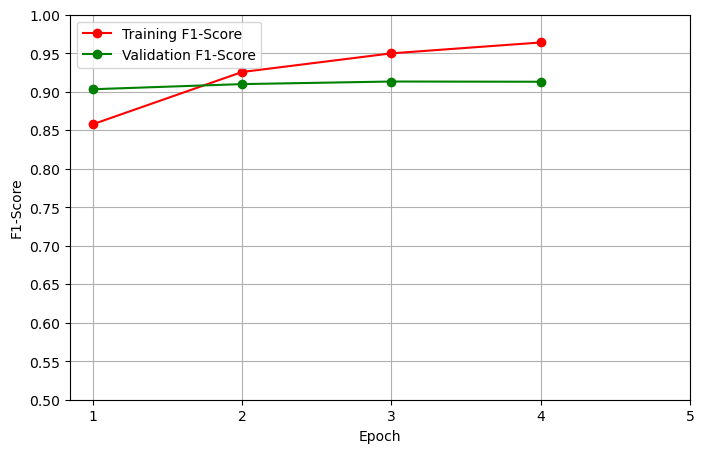

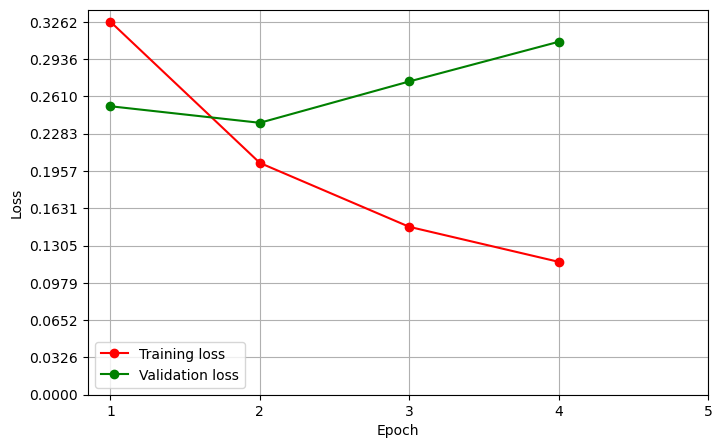

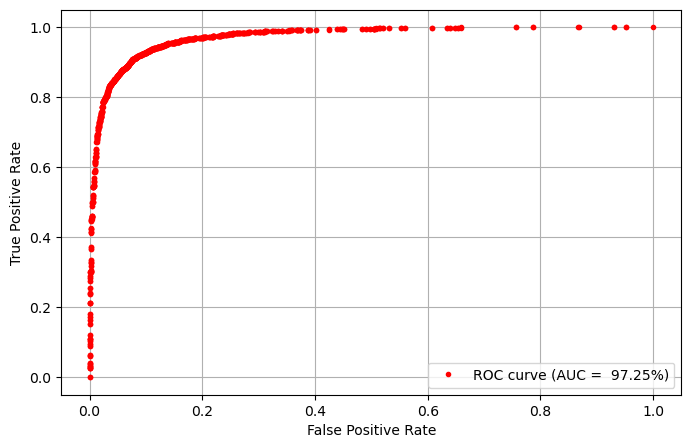

In [30]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True, id='B01',
              
              device='cuda', lr=1e-5, epochs=4, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'dropout' : 0.4},
              
              clip=1
              )

Model ID : B01
Time taken: 2712.77	Avg loss: 0.287057	Accuracy: 88.28%
Precision: 88.44%	Recall: 88.04%		F1-Score: 88.24%


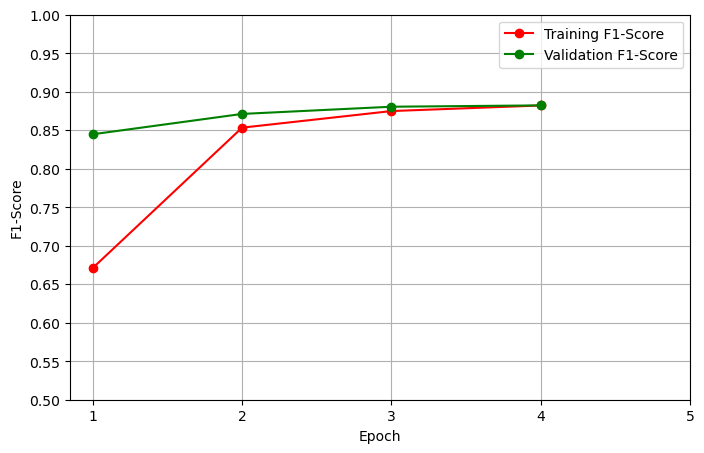

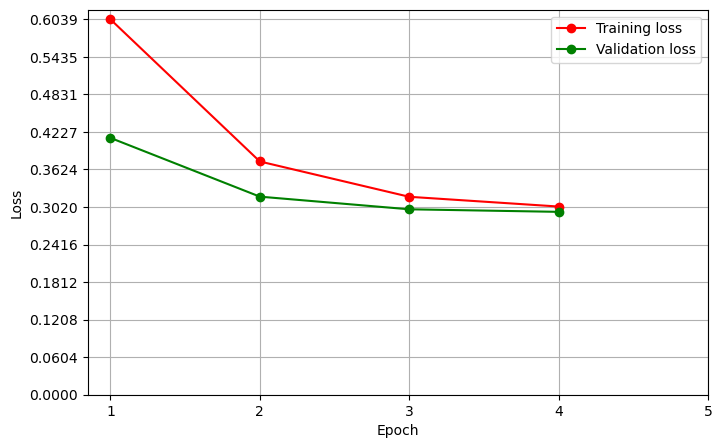

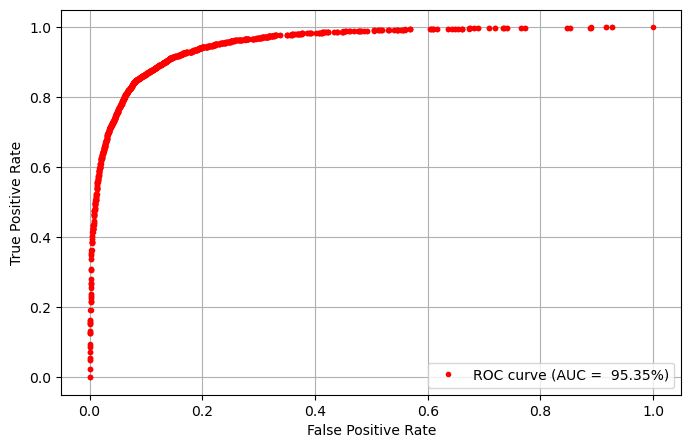

In [31]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True, id='B02',
              
              device='cuda', lr=1e-6, epochs=4, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'dropout' : 0.6},
              
              
              clip=1
              )

Model ID : B03
Time taken: 2707.62	Avg loss: 0.228222	Accuracy: 90.83%
Precision: 90.64%	Recall: 91.05%		F1-Score: 90.85%


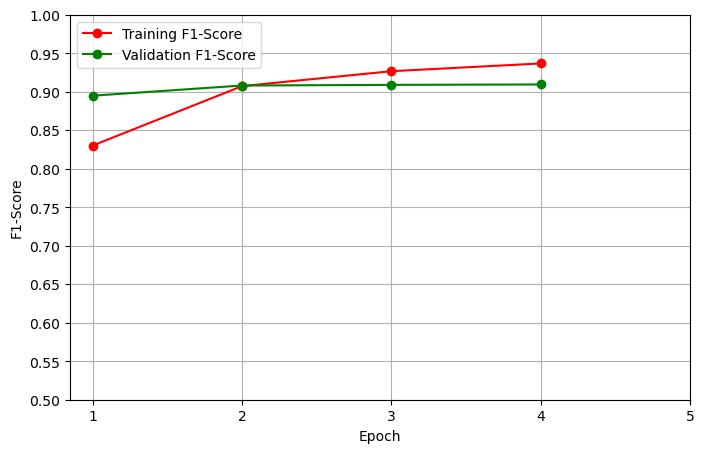

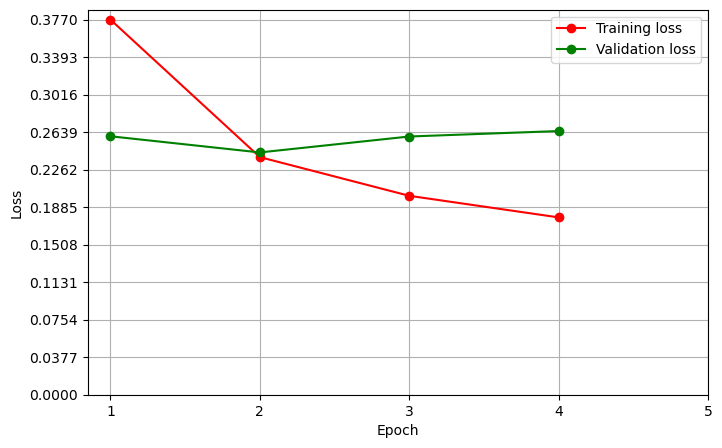

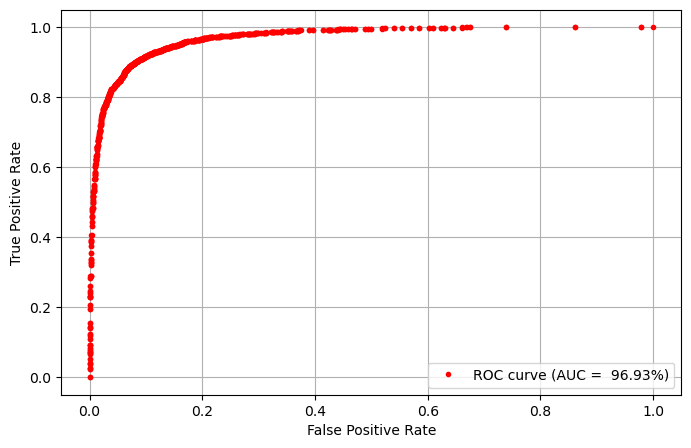

In [33]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True, id='B03',
              
              device='cuda', lr=5e-6, epochs=4, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'dropout' : 0.6},
              
              
              clip=1
              )

Model ID : B04
Time taken: 2902.83	Avg loss: 0.272571	Accuracy: 89.32%
Precision: 89.49%	Recall: 89.09%		F1-Score: 89.29%


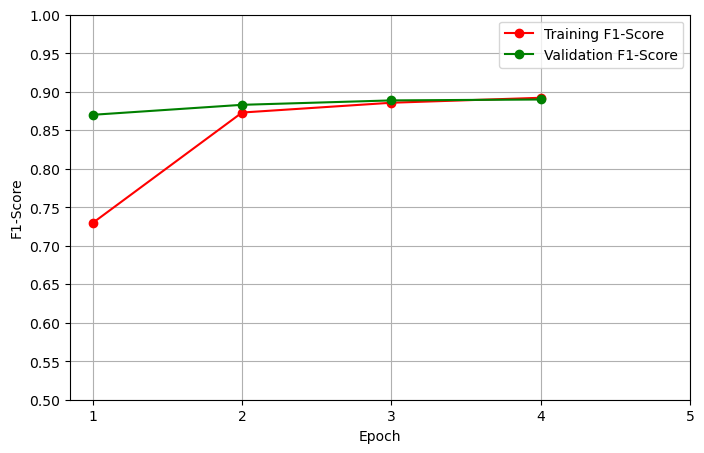

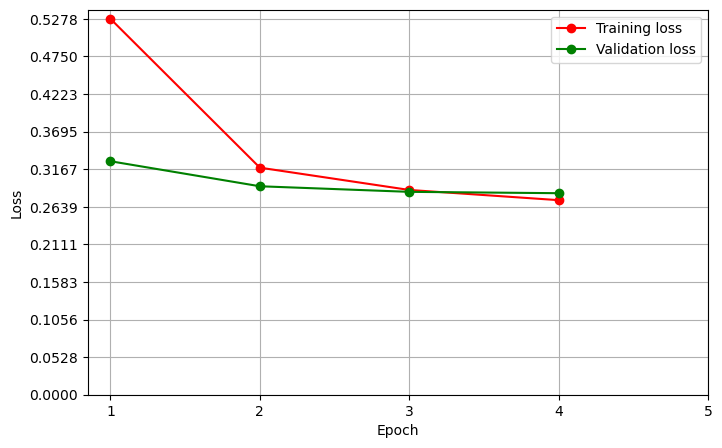

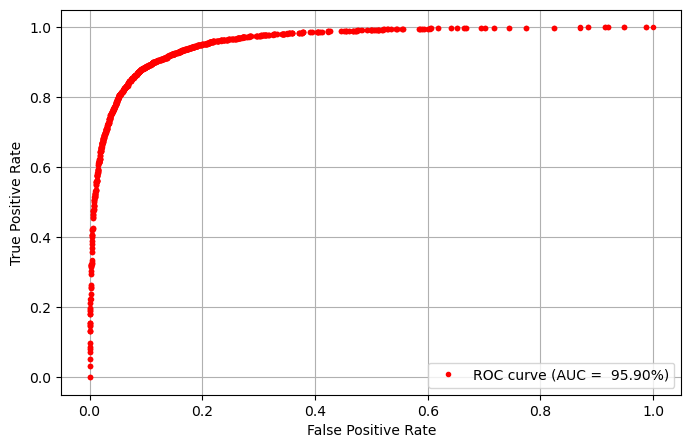

In [23]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True, id='B04',
              
              device='cuda', lr=1e-6, epochs=4, batch_size=16,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'dropout' : 0.6},
                            
              clip=1
              )

Model ID : B05
Time taken: 3174.40	Avg loss: 0.267987	Accuracy: 90.94%
Precision: 90.45%	Recall: 91.52%		F1-Score: 90.99%


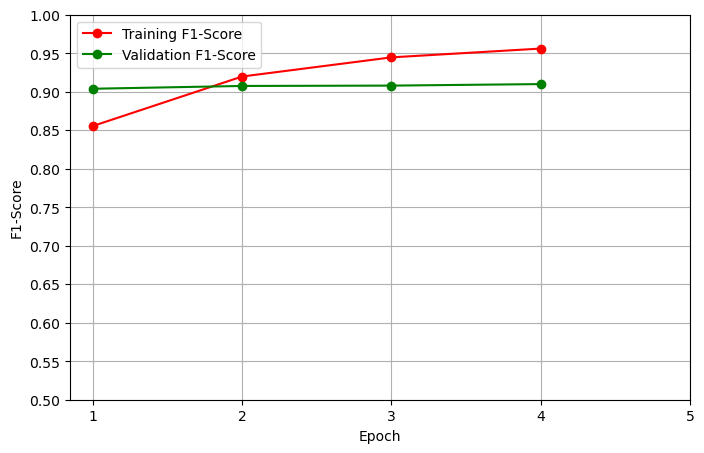

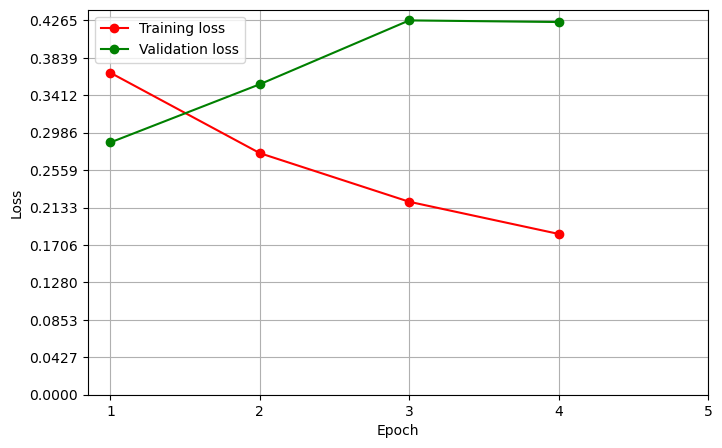

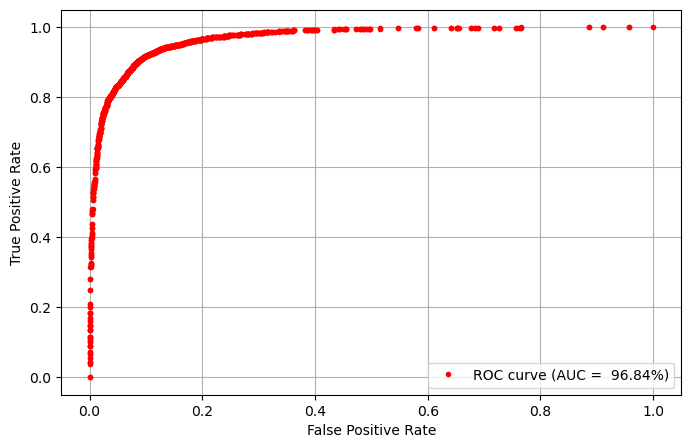

In [25]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, lc=True, auroc=True, id='B05',
              
              device='cuda', lr=5e-6, epochs=4, batch_size=8,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'dropout' : 0.6},
                            
              clip=1
              )


Epoch 1
-------------------------------
Loss on train set     : 0.5955440068428116
Loss on validation set: 0.39281476148456895
F1-score on validation set: 85.23
Best epoch so far

Epoch 2
-------------------------------
Loss on train set     : 0.35899521213192187
Loss on validation set: 0.30465787944366346
F1-score on validation set: 87.79
Best epoch so far

Epoch 3
-------------------------------
Loss on train set     : 0.3007991380602051
Loss on validation set: 0.28569064305146347
F1-score on validation set: 88.60
Best epoch so far

Epoch 4
-------------------------------
Loss on train set     : 0.2783586597840696
Loss on validation set: 0.2792651040198387
F1-score on validation set: 88.98
Best epoch so far

Epoch 5
-------------------------------
Loss on train set     : 0.26374349590769613
Loss on validation set: 0.27122062755713483
F1-score on validation set: 89.28
Best epoch so far

Epoch 6
-------------------------------
Loss on train set     : 0.25444115006120493
Loss on valida

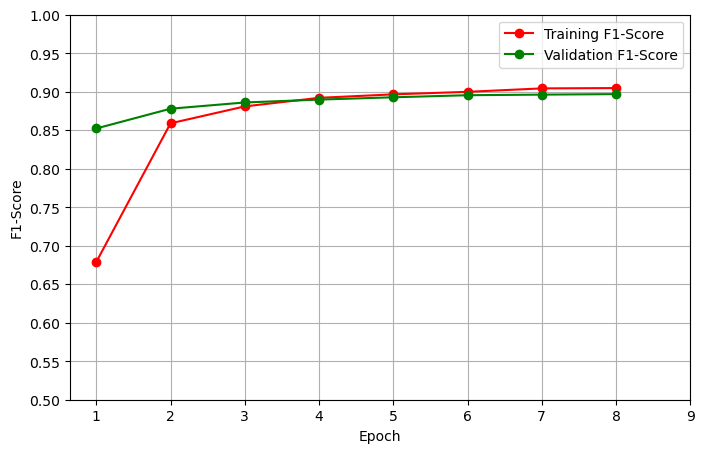

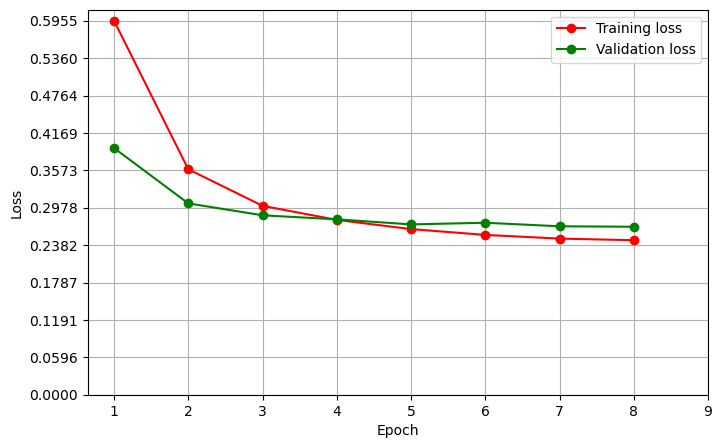

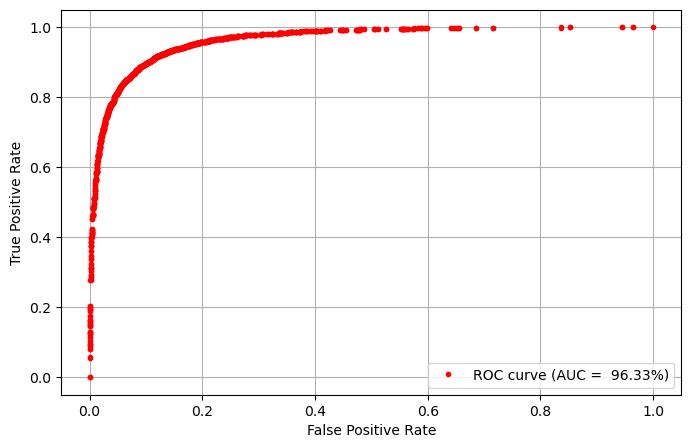

In [27]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, show_epochs=True, lc=True, auroc=True, id='B06',
              
              device='cuda', lr=1e-6, epochs=8, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'dropout' : 0.6},
              
              clip=1
              )


Epoch 1
-------------------------------
Loss on train set     : 0.4230746557015758
Loss on validation set: 0.27706171969338406
F1-score on validation set: 88.72
Best epoch so far

Epoch 2
-------------------------------
Loss on train set     : 0.26659966845849165
Loss on validation set: 0.2534071030446662
F1-score on validation set: 90.17
Best epoch so far

Epoch 3
-------------------------------
Loss on train set     : 0.22755818035955547
Loss on validation set: 0.260012785130936
F1-score on validation set: 90.34

Epoch 4
-------------------------------
Loss on train set     : 0.206832936482755
Loss on validation set: 0.26877143020513206
F1-score on validation set: 90.51

Epoch 5
-------------------------------
Loss on train set     : 0.1912338613107554
Loss on validation set: 0.26233418823553706
F1-score on validation set: 90.65

Epoch 6
-------------------------------
Loss on train set     : 0.18082854845924368
Loss on validation set: 0.26501094864435354
F1-score on validation set:

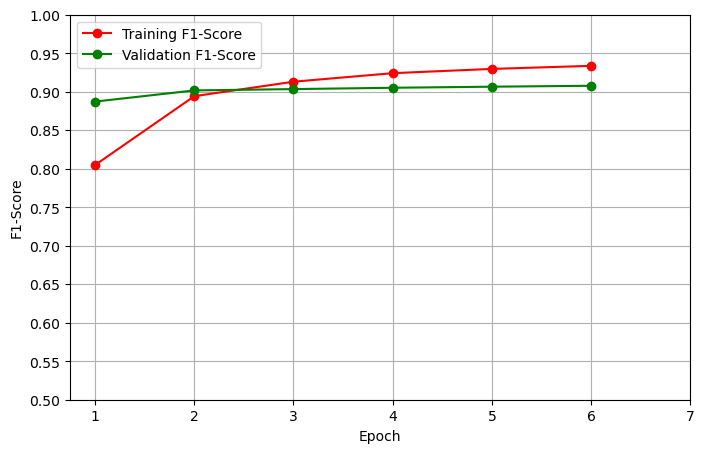

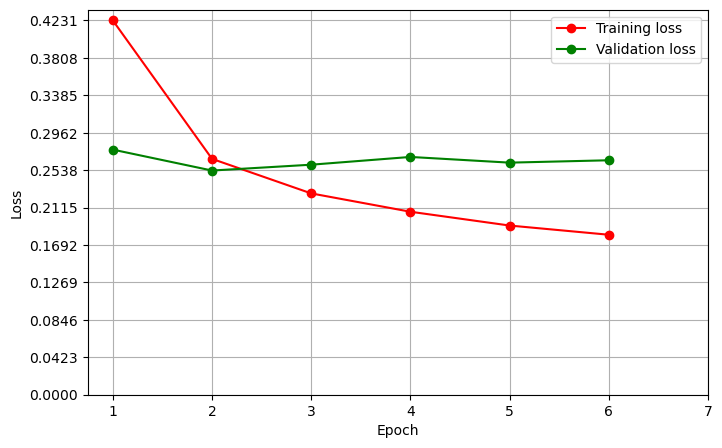

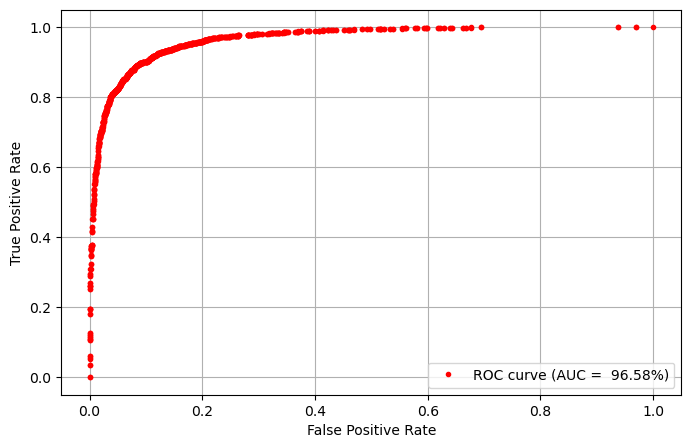

In [29]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, show_epochs=True, lc=True, auroc=True, id='B07',
              
              device='cuda', lr=3e-6, epochs=6, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'dropout' : 0.6},
              
              clip=1
              )


Epoch 1
-------------------------------
Loss on train set     : 0.4855816109946997
Loss on validation set: 0.3004798137776132
F1-score on validation set: 87.94
Best epoch so far

Epoch 2
-------------------------------
Loss on train set     : 0.2914471829631509
Loss on validation set: 0.2705335946894198
F1-score on validation set: 89.33
Best epoch so far

Epoch 3
-------------------------------
Loss on train set     : 0.2534843574522446
Loss on validation set: 0.2658035308737659
F1-score on validation set: 89.87
Best epoch so far

Epoch 4
-------------------------------
Loss on train set     : 0.23499691057465882
Loss on validation set: 0.2658975455417948
F1-score on validation set: 90.14

Epoch 5
-------------------------------
Loss on train set     : 0.2214956407173235
Loss on validation set: 0.26118464558824617
F1-score on validation set: 90.13
Best epoch so far

Epoch 6
-------------------------------
Loss on train set     : 0.2141110131838502
Loss on validation set: 0.26090813886

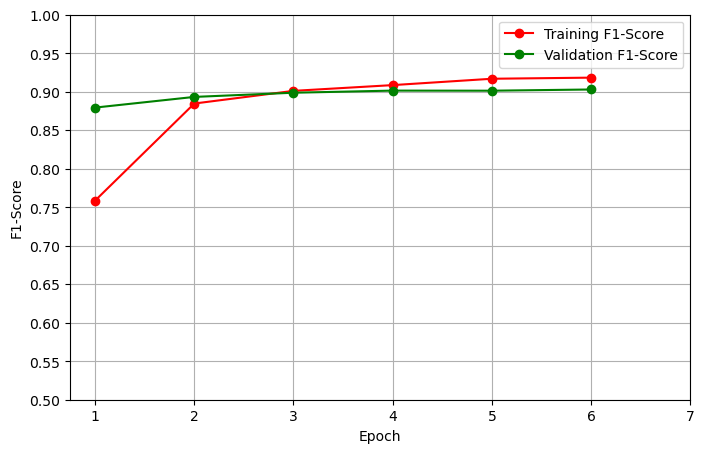

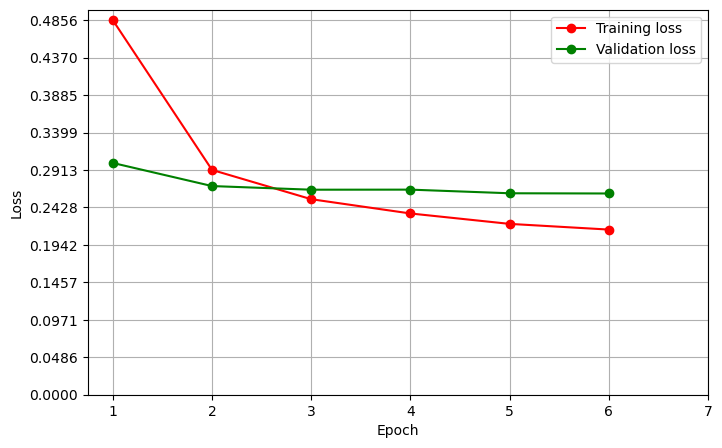

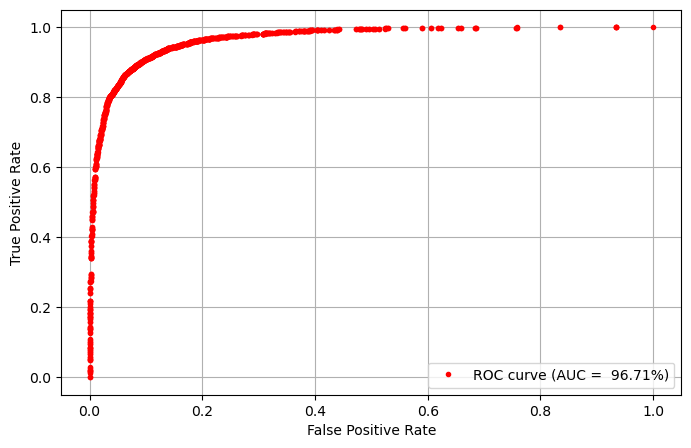

In [22]:
complete_pass(data_path=DATASETS, validate=True, reproducibility=True, show_epochs=True, lc=True, auroc=True, id='B08',
              
              device='cuda', lr=2e-6, epochs=6, batch_size=32,

              model=Bert, model_params={'bert' : BertModel, 'bert_name' : 'bert-base-uncased', 'dropout' : 0.6},
              
              clip=1
              )